In [1]:
%matplotlib inline

## Calibration

This notebook demonstrates how the user might calibrate the model to a multiple gauging stations. <br>
The default approach in the AWRACMS is to calibrate multiple catchments to a single set of parameters.

This notebook goes through the following steps:

1. Import required libraries
2. Set up calibration configuration <br>
 2.1 Catchments to be calibrated<br>
 2.2 Period to calibrate over<br>
 2.3 Define forcing and observation inputs<br>
 2.4 Select Optimiser, e,g sce<br>
 2.5 Define objective functions<br>
 2.6 Combine into a specification dictionary<br>
3. Run model calibration<br>
4. Extract best parameter set<br>
5. Visualise calibration process outputs<br>
6. Exercises


### 1. Import required libraries

In [2]:
from os.path import join

import h5py
from matplotlib import pyplot as plt
import pandas as pd

from awrams.utils import config_manager, extents, gis
from awrams.utils import datetools as dt
from awrams.utils.gis import ShapefileDB
from awrams.utils.nodegraph import nodes, graph

from awrams.calibration.optimizers import sce
from awrams.calibration.objectives import test_objectives as tobj
from awrams.calibration import support
from awrams.calibration import cluster
from awrams.calibration.launch_calibration import run_from_pickle

import awrams.visualisation.vis as vis

### 2. Define calibration configuration

#### 2.1 Pick a catchment from the default catchments dataset

In [3]:
# Use sys_settings for paths
sys_settings = config_manager.get_system_profile().get_settings()
base_data_path = sys_settings['DATA_PATHS']['BASE_DATA']
catchments_shapefile = join(base_data_path, 'spatial/shapefiles/Final_list_all_attributes.shp')

calvalshapefile = ShapefileDB(catchments_shapefile)

# Define the extents of the calibration
def_extent = extents.get_default_extent() 

In [4]:
# Single catchment
my_extent = calvalshapefile.get_extent_by_field('StationID', '003303', parent_extent=def_extent)
my_extent

origin: -24.25,145.45, shape: (17, 27), cell_size: 0.05

In [5]:
 ## Create a dict with multiple extents
cal_dict = {}
cal_catchments = ['105001', '145003']

for catchment in cal_catchments:
    cal_dict[catchment] = calvalshapefile.get_extent_by_field('StationID', catchment.zfill(6), parent_extent=def_extent)

cal_dict

{'105001': origin: -15.2,143.6, shape: (9, 8), cell_size: 0.05,
 '145003': origin: -28.2,152.6, shape: (4, 5), cell_size: 0.05}

/home/dshipman/IGIT/WINTRANSFER/awrams_cm/packages/awrams/visualisation/vis.py:81: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  to_plot.data[c_ext.indices][c_ext.mask==False] = 2.0


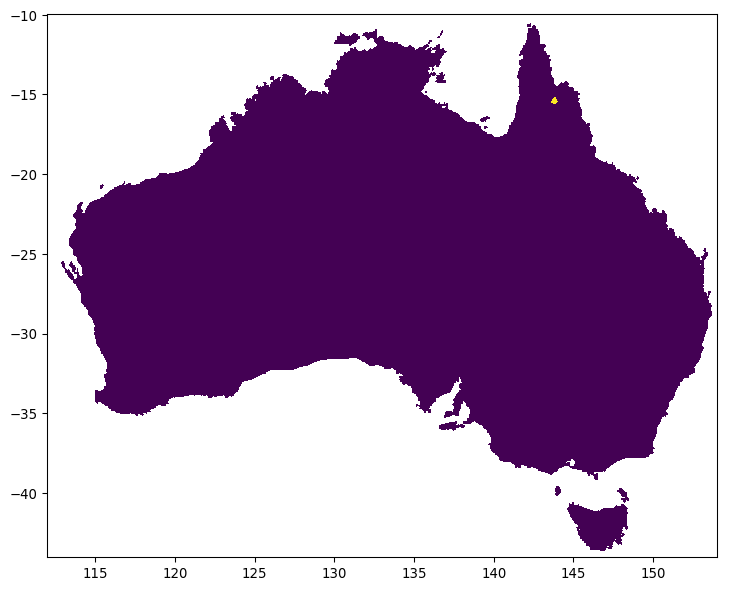

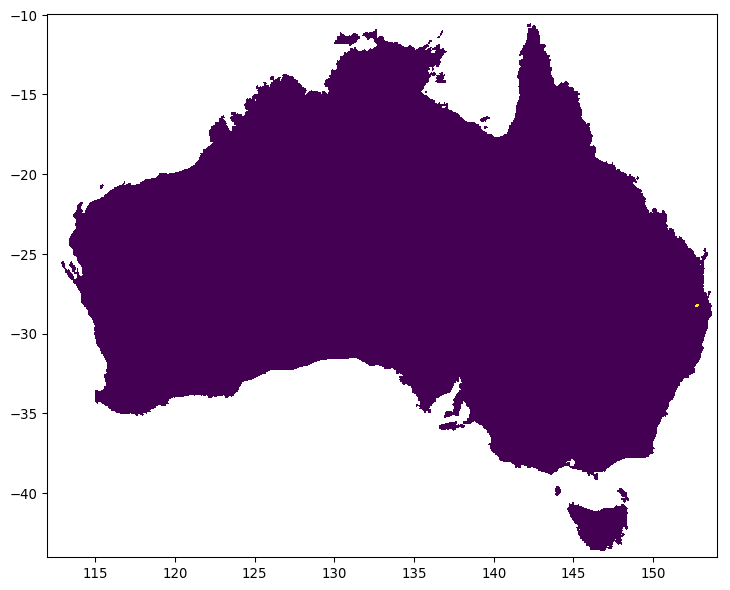

In [6]:
## Check out where the catchments are
vis.show_extent(cal_dict['105001'], def_extent)
vis.show_extent(cal_dict['145003'], def_extent)

#### 2.2 Specify running and calibration period

In [7]:
run_period = dt.dates('2009 - 2010')
eval_period = dt.dates('2009 - 2010')

#### 2.3 Specify forcing inputs and observations

In [8]:
# 2.3.1 Specify observation location
observations = dict(qtot=join(base_data_path, 'observations/runoff/awrams_v5_cal_qobs.csv'))

In [9]:
model_profile = config_manager.get_model_profile('awral', 'v6_default')
input_map = model_profile.get_input_mapping()

#### 2.4 Select optimiser

 - The **Shuffled-Complex evolution (SCE)** algorithm of Duan et al (1993) is used for finding and optimum parameter set 
     - Duan, Q.Y., Gupta, V.K. & Sorooshian, S. J Optim Theory Appl (1993) 76: 501. https://doi.org/10.1007/BF00939380

In [10]:
evolver_spec = support.EvolverSpec(sce.CCEvolver,
                                   evolver_run_args=dict(n_offspring=1, n_evolutions=5, elitism=2.0))

optimizer_spec = support.OptimizerSpec(sce.ShuffledOptimizer,
                                       evolver_spec=evolver_spec,
                                       n_complexes=5,
                                       max_nsni=500,
                                       min_complexes=1,
                                       max_eval=2000) #n_complex 14

#### 2.5 Import objective function

In [11]:
from awrams.calibration.objectives import test_objectives as tobj

In [12]:
# %load ../../calibration/awrams/calibration/objectives/test_objectives.py
from awrams.calibration import objectives
from awrams.calibration.support import input_group
import numpy as np

obs = np.linspace(0.,1.,365)

def test_nse():
	nse = NSE(obs)
	assert( nse(obs) == 1.0 )
	assert( nse(np.repeat(obs.mean(),365)) == 0.0 )

def test_bias():
	bias = Bias(obs)
	assert( bias(obs) == 0.0 )
	assert( bias(obs*2.0) == 1.0 )

class LocalQTotal:
    '''
    Simple sum of run
    '''

    #input_schema = ['qtot','etot','dd']
    input_schema = input_group(['qtot','etot','dd'],'volume')
    output_schema = ['qtot_vol','etot_vol','dd_vol']

    def __init__(self,obs,eval_period):
        pass

    def evaluate(self,modelled):
        return np.array((np.sum(modelled['qtot']),np.sum(modelled['etot']),np.sum(modelled['dd'])))

class GlobalQTotal:

    output_schema = ['qtot_vol','etot_vol','dd_vol']
    objective_key = 'qtot_vol'

    def evaluate(self,l_results):
        out_d = dict( [(k, np.sum(l_results[k])) for k in self.output_schema] )
        return out_d

class TestLocalSingle:

    input_schema = input_group(['qtot'])
    output_schema = ['qtot_nse']

    def __init__(self,obs,eval_period,min_valid=15):

        self.valid_idx = {}
        self.nse = {}
        self.flow_variable = 'qtot'
        for k in [self.flow_variable]:

            data = obs[k]

            if np.isnan(data).any():
                nan_mask = np.isnan(data)
                self.valid_idx[k] = np.where(nan_mask == False)
            else:
                self.valid_idx[k] = slice(0,len(eval_period))

            self.nse[k] = NSE(data[self.valid_idx[k]])

    def evaluate(self,modelled):
        qtot_nse = self.nse[self.flow_variable](modelled[self.flow_variable][self.valid_idx[self.flow_variable]])
        return np.array(qtot_nse)

class TestGlobalSingle:

    output_schema = ['objf_val']
    objective_key = 'objf_val'

    def evaluate(self,l_results):
        objf_val = 1.0 - np.mean(l_results['qtot_nse'])
        return dict(objf_val = objf_val)

class TestLocalMulti:

    input_schema = input_group(['qtot','etot'])
    output_schema = ['qtot_nse','etot_nse']

    def __init__(self,obs,eval_period,min_valid=15,flow_variable='qtot_avg',et_variable='etot_avg'):

        self.valid_idx = {}
        self.nse = {}

        self.flow_variable = flow_variable
        self.et_variable = et_variable
        
        for k in [flow_variable,et_variable]:

            data = obs[k]

            if np.isnan(data).any():
                nan_mask = np.isnan(data)
                self.valid_idx[k] = np.where(nan_mask == False)
            else:
                self.valid_idx[k] = slice(0,len(eval_period))

            self.nse[k] = NSE(data[self.valid_idx[k]])

    def evaluate(self,modelled):
        qtot_nse = self.nse[self.flow_variable](modelled[self.flow_variable][self.valid_idx[self.flow_variable]])
        etot_nse = self.nse[self.et_variable](modelled[self.et_variable][self.valid_idx[self.et_variable]])
        return dict(qtot_nse=qtot_nse,etot_nse=etot_nse)

class TestGlobalMultiEval:

    output_schema = ['objf_val','qtot_nse','etot_nse']
    objective_key = 'objf_val'

    def evaluate(self,l_results):
        qtot_nse = np.mean(l_results['qtot_nse'])
        etot_nse = np.mean(l_results['etot_nse'])
        objf_val = 1.0 - (qtot_nse+etot_nse) * 0.5
        #return 1.0 - np.mean((l_results['qtot_nse'] + l_results['etot_nse']) * 0.5)
        return dict(objf_val = objf_val, qtot_nse=qtot_nse, etot_nse=etot_nse)


In [13]:
local_objfspec = support.ObjectiveFunctionSpec(tobj.TestLocalSingle)  # this function to load up the ObjFunc comes from awrams.calibration.support
global_objfspec = tobj.TestGlobalSingle

In [14]:
objective_spec = support.ObjectiveSpec(global_objfspec,
                                       local_objfspec,
                                       observations,
                                       eval_period)

#### 2.6. Build spec dict

Assemble above settings into specification dictionary

In [15]:
# Get an instance of the model
model = model_profile.get_model()

In [16]:
# Create the calibration specification dictionary

'''
User specifiable calibration description
'''
cal_spec = {}
cal_spec['optimizer_spec'] = optimizer_spec
cal_spec['objective_spec'] = objective_spec
cal_spec['extent_map'] = cal_dict
cal_spec['run_period'] = run_period
cal_spec['model'] = model
cal_spec['node_mapping'] = input_map
cal_spec['logfile'] = './calres.h5'

In [17]:
# Save a file containing all the calibration specifications
nnodes = 1
ncores = 4
cluster.build_pickle_from_spec(cal_spec, ncores, nnodes, 'test_cal.pkl')

{'optimizer_spec': <awrams.calibration.support.OptimizerSpec at 0x7f578183ba90>,
 'objective_spec': <awrams.calibration.support.ObjectiveSpec at 0x7f57818476a0>,
 'extent_map': {'105001': origin: -15.2,143.6, shape: (9, 8), cell_size: 0.05,
  '145003': origin: -28.2,152.6, shape: (4, 5), cell_size: 0.05},
 'run_period': DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
                '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
                '2009-01-09', '2009-01-10',
                ...
                '2010-12-22', '2010-12-23', '2010-12-24', '2010-12-25',
                '2010-12-26', '2010-12-27', '2010-12-28', '2010-12-29',
                '2010-12-30', '2010-12-31'],
               dtype='datetime64[ns]', length=730, freq='D'),
 'model': <awrams.models.awral.model.AWRALModel at 0x7f5781847e48>,
 'node_mapping': alb_dry_hrudr: parameter([]):{'value': 0.26, 'min_val': 0.1, 'max_val': 0.5, 'fixed': True, 'description': 'HRU:DR Dry Soil Albedo'}
 a

### 3. Run the calibration

In [18]:
cal = run_from_pickle('./test_cal.pkl')

mpirun --oversubscribe --allow-run-as-root --mca plm_rsh_agent false -x TMPDIR=/dev/shm/ -n 1 --map-by ppr:1:node python3 -m awrams.calibration.server ./test_cal.pkl : -x TMPDIR=/dev/shm/ -n 1 --map-by ppr:1:node python3 -m awrams.calibration.node
s:  13688
Node starting on sdcvd-awrap01.bom.gov.au
Logger setup complete

 evaluating initial population
{}
......
 running
{'n_eval': 215, 'n_shuffle': 0, 'best_params': Score: 0.736880821118, Params: [ 0.0458999   0.04326281  0.2074315   0.82519241  0.65576483  7.29582519
  4.62578128  2.41653654  2.2434171   0.86762866  0.9282149   0.1462411
  0.48561721  2.75974071  0.92483746  0.06020117  0.36121213  0.71562666
  0.53588317  1.67661838  6.9802402 ], Meta: None}

 running
{'n_eval': 241, 'n_shuffle': 1, 'best_params': Score: 0.736880821118, Params: [ 0.0458999   0.04326281  0.2074315   0.82519241  0.65576483  7.29582519
  4.62578128  2.41653654  2.2434171   0.86762866  0.9282149   0.1462411
  0.48561721  2.75974071  0.92483746  0.0602011


 running
{'n_eval': 787, 'n_shuffle': 71, 'best_params': Score: 0.526290661141, Params: [ 0.03778297  0.04847502  0.09630778  0.92641746  0.81530054  1.83148323
  1.47692359  1.14917231  0.05189607  0.83361928  0.0664711   0.05233112
  0.43758296  2.43346575  2.674756    0.07841181  0.35623353  0.57233491
  0.5247598   1.47618682  5.90835382], Meta: None}

 running
{'n_eval': 815, 'n_shuffle': 75, 'best_params': Score: 0.526290661141, Params: [ 0.03778297  0.04847502  0.09630778  0.92641746  0.81530054  1.83148323
  1.47692359  1.14917231  0.05189607  0.83361928  0.0664711   0.05233112
  0.43758296  2.43346575  2.674756    0.07841181  0.35623353  0.57233491
  0.5247598   1.47618682  5.90835382], Meta: None}

 running
{'n_eval': 847, 'n_shuffle': 80, 'best_params': Score: 0.519565953351, Params: [ 0.03453054  0.04709077  0.07799013  0.96796492  0.83223525  2.24012551
  2.1863756   0.59789414  0.09862112  0.67800328  0.09093904  0.05852313
  0.41158213  2.57880437  2.82799453  0.1841992


 running
{'n_eval': 1538, 'n_shuffle': 195, 'best_params': Score: 0.453902837055, Params: [ 0.02474026  0.04750018  0.04151942  0.99863133  0.9881928   9.88863276
  0.96506768  0.43245561  0.05040432  0.98874437  0.12268912  0.05562942
  0.31067018  2.89799167  1.91787558  0.03501155  0.0432096   0.87373864
  0.61621621  1.54960988  9.0565934 ], Meta: None}

 running
{'n_eval': 1561, 'n_shuffle': 199, 'best_params': Score: 0.451603734095, Params: [ 0.02569251  0.04899546  0.0418669   0.9989701   0.99679102  8.82003556
  0.9074568   0.4536807   0.0502487   0.96960276  0.13487048  0.05600021
  0.30647696  2.89976141  1.07272006  0.0397478   0.0334181   0.96304555
  0.38337408  1.48485797  8.88787403], Meta: None}

 running
{'n_eval': 1586, 'n_shuffle': 204, 'best_params': Score: 0.451188035053, Params: [ 0.02609329  0.04825719  0.04242939  0.99605458  0.9997718   9.25118772
  0.93473487  0.44240654  0.05008641  0.95142311  0.13719699  0.05653348
  0.31375379  2.94105482  1.07024967  0.0

### 4. Extract best parameter set

The calibration process creates a file containing all the parameters and objective scores of each iteration of the calibration.

In [19]:
cr = support.CalibrationResults('./calres.h5')

In [20]:
# These are the parameters we calibrated against
cr.get_best_paramset()

,min_val,max_val,value,fixed,description
alb_dry_hrudr,0.100,0.50,0.260000,True,HRU:DR Dry Soil Albedo
alb_dry_hrusr,0.100,0.50,0.260000,True,HRU:SR Dry Soil Albedo
alb_wet_hrudr,0.100,0.50,0.160000,True,HRU:DR Wet Soil Albedo
alb_wet_hrusr,0.100,0.50,0.160000,True,HRU:SR Wet Soil Albedo
cgsmax_hrudr,0.020,0.05,0.026125,False,HRU:DR Conversion Coefficient From Vegetation ...
cgsmax_hrusr,0.020,0.05,0.049840,False,HRU:SR Conversion Coefficient From Vegetation ...
er_frac_ref_hrudr,0.040,0.25,0.040150,False,HRU:DR Ratio of Average Evaporation Rate Over ...
fsoilemax_hrudr,0.200,1.00,0.999737,False,HRU:DR Soil Evaporation Scaling Factor When So...
fsoilemax_hrusr,0.200,1.00,0.999545,False,HRU:SR Soil Evaporation Scaling Factor When So...
fvegref_g_hrudr,0.100,0.25,0.150000,True,HRU:DR Reference Soil Cover Fraction That Dete...


In [21]:
# Get a DataFrame of the parameter values over time (iterations)
params_all = cr.get_parameter_values()

In [22]:
# Obtain the best (minimum score) parameter set
# Note that CalibrationResults.get_best_paramset() performs the same function

best_params = params_all.iloc[cr.best_param_index()]
best_params

#best_params.to_csv('cal_params_test.csv')

cgsmax_hrudr         0.026125
cgsmax_hrusr         0.049840
er_frac_ref_hrudr    0.040150
fsoilemax_hrudr      0.999737
fsoilemax_hrusr      0.999545
k0sat_scale          9.672734
k_gw_scale           0.660041
k_rout_int           0.432418
k_rout_scale         0.050101
kdsat_scale          0.972466
kr_coeff             0.106091
kssat_scale          0.059793
ne_scale             0.311256
pref_gridscale       2.998520
s0max_scale          0.574878
s_sls_hrudr          0.030025
s_sls_hrusr          0.030919
sdmax_scale          0.999405
slope_coeff          0.513961
ssmax_scale          1.358564
ud0_hrudr            9.878697
Name: 1998, dtype: float64

### 5. Take a look at the calibration outputs

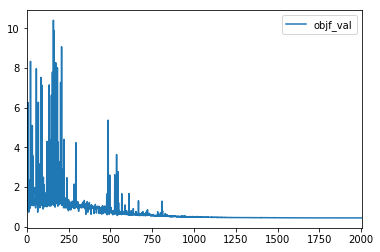

In [23]:
# Examine the change in global objective function values over time

gscores = cr.get_global_scores()
gscores.plot()

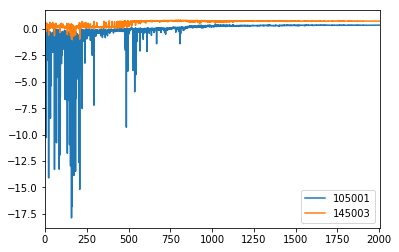

In [24]:
#Get some local (catchment level) scores

qnse_l = cr.get_local_scores('qtot_nse')
qnse_l.plot()

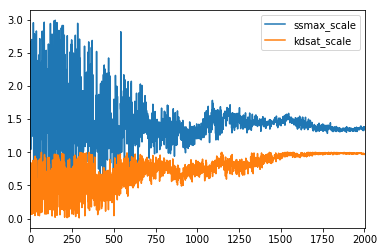

In [25]:
#Observe the evolution in parameter values over iterations
#Great for examining behaviour of parameter space for different optimizers!

params_all[['ssmax_scale', 'kdsat_scale']].plot()

### 6. Compare modelled and observed outputs

In [26]:
#Load up an OnDemand simulator to run the model

from awrams.simulation import ondemand

sim = ondemand.OnDemandSimulator(model, input_map)

In [27]:
# Load observations for comparison

obs_df = pd.DataFrame.from_csv(observations['qtot'])

In [28]:
# Set the new (calibrated) parameters

sim.input_runner.set_parameters(best_params)

In [29]:
sim_res = sim.run(run_period, cal_dict['145003'])
sim_res['dd'].shape

(730, 4, 5)

In [30]:
pd.DataFrame.from_records(sim_res['dd'])

,0,1,2,3
0,"[--, 8.91597685734, 13.0053409696, 10.78791331...","[10.598773532, 9.79641823533, 16.6343796451, 1...","[7.72775087187, 6.97020375245, 14.1618782607, ...","[--, 7.78938360668, 10.6584423554, 12.75389569..."
1,"[--, 8.43932168098, 12.0563389846, 10.10235427...","[9.95689676686, 9.25707678113, 15.123313395, 1...","[7.38843488177, 6.69029092593, 13.0529158517, ...","[--, 7.4222474102, 9.98845809696, 11.814130551..."
2,"[--, 8.00105584827, 11.2058776032, 9.478163433...","[9.37409961713, 8.7648282118, 13.8112410619, 1...","[7.07448648006, 6.43172435411, 12.0808807467, ...","[--, 7.09013837433, 9.39514724836, 10.98843221..."
3,"[--, 7.58147753001, 10.4221976613, 8.895472492...","[8.82446331261, 8.29962517969, 12.6413501723, ...","[6.77127588258, 6.1804454687, 11.1953085259, 1...","[--, 6.76658833227, 8.83391962841, 10.22477768..."
4,"[--, 7.16773987815, 9.68189935008, 8.332613762...","[8.27920513807, 7.83552146229, 11.553686807, 8...","[6.45746487113, 5.91861661554, 10.3508378656, ...","[--, 6.42356151795, 8.27018323133, 9.485368915..."
5,"[--, 6.7605847074, 8.97929032092, 7.7922580596...","[7.74695284294, 7.37798793658, 10.5447006064, ...","[6.14130285081, 5.65039959613, 9.55291755487, ...","[--, 6.07780234107, 7.72050663272, 8.781498725..."
6,"[--, 6.3947832426, 8.35710105222, 7.3112525089...","[7.27513764899, 6.97122189669, 9.67799999496, ...","[5.8573274768, 5.40943209223, 8.8563284785, 10...","[--, 5.77141738085, 7.2391919564, 8.1667834685..."
7,"[--, 6.06810260202, 7.81284999021, 6.889627928...","[6.86273400652, 6.61083916747, 8.93700962179, ...","[5.60726225426, 5.19612853648, 8.25584458266, ...","[--, 5.50639552117, 6.8272669393, 7.6436986578..."
8,"[--, 5.76700395544, 7.31271110862, 6.495982674...","[6.48236932256, 6.27946368, 8.27284736155, 6.8...","[5.37864094108, 5.00692548982, 7.73501722956, ...","[--, 5.28322356717, 6.47743972376, 7.193136452..."
9,"[--, 5.48489149209, 6.85682411632, 6.134878470...","[6.13439836893, 5.97339255112, 7.67892419662, ...","[5.16280923052, 4.82200797297, 7.24875750702, ...","[--, 5.05990451948, 6.13613843611, 6.761788170..."


In [31]:
#sim_res.to_csv('/data/cwd_awra_data/AWRACMS/Training/test_data/105001sim.csv')

In [32]:
#Simulations output gridded data; get some convenience aggregation functions

from awrams.calibration.support import aggregate, flattened_areas

def mean_by_extent(in_data, extent):
    weights = flattened_areas(extent)
    return aggregate(in_data, weights, weights.sum())

In [33]:
comp_df = pd.DataFrame()
sim_res['qtot'].shape
#cal_dict['145003'].shape
#comp_df['modelled'] = pd.Series(mean_by_extent(sim_res['qtot'],cal_dict['145003']),index=run_period)
#comp_df['obs'] = obs_df['145003'][run_period]
#comp_df.plot()

(730, 4, 5)

In [34]:
# Deliberately get the worst parameter set, just to see how bad it is...

worst_params = cr.get_best_paramset(reverse=True)

In [ ]:
cr.get_best_paramset?

In [35]:
sim.input_runner.set_parameters(worst_params)
bad_res = sim.run(run_period, cal_dict['105001'], False, False)
bad_res['qtot'].shape

KeyError: 'min_val'

In [ ]:
comp_df = pd.DataFrame()
comp_df['modelled'] = pd.Series(mean_by_extent(bad_res['qtot'], cal_dict['105001']), index=run_period)
comp_df['obs'] = obs_df['105001'][run_period]
comp_df.plot()

## Exercise A
#### Re-calibrate to only one catchment
#### Use the parameters from the two calibrations in 2 ondemand simulations for the set of catchments
#### Compare flows from the models to the observations

## Exercise B

The [Putting_it_all_in_practice] workbook in the Training/Workspace folder where the steps are outlined in a bit more detail.

#### Use the provided set of Tasmanian catchments and repeat the calibration process.

#### Follow it up by doing some benchmarking, visualisation in the following session

[Putting_it_all_in_practice]: ../Workspace/Putting_it_all_in_practice.ipynb